In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
import pyamg

# Problem 1. Find an efficient smoother for the following structured problem

In [2]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

sten = np.zeros((3,3))
sten[[0,1,1,2],[1,0,2,1]] = -1
sten[1,1] = 4

A = stencil_grid(sten, (4,4))

### Set up the operators

Let us consider the following problem:
$$
-\varepsilon u_{xx} - u_{yy} = f(x,y)
$$
defined on a square domain with zero boundary conditions.

The application of the finite diference discretization to the above problem yields the following stencil:
$$
\left[
\begin{array}{rrr}
 & -1 & \\
 -\varepsilon & 2 + 2\varepsilon & -\varepsilon\\
 & -1 &
\end{array}
\right]
$$

I have prepared one smoothers (relaxJ) as well as stencil generation and interpolation in the following cell. You can use them directly.



In [3]:
def relaxJ(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5

    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)

    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n, epsilon=1):
    """
    Create a 2D operator from a stencil.
    """
    #sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    sten = np.array([[ 0      ,           -1.,  0],
                     [-epsilon,  2+2*epsilon, -epsilon],
                     [0       ,           -1,  0]])
    A = stencil_grid(sten, (n, n))
    return A

## 1.1  Smoothing effect on this problem

Run the following three cells with three different `epsilon = 100, 1, 0.001`.

To determine the effectiveness of the smoother relaxJ, one should identify the scenarios in which it performs optimally. This can be achieved by calculating the eigenvalues of the smoother relaxJ. Please derive the eigenvalues and eigenvectors of relaxJ and use the eigenvalues to explain the patterns in the three plots.

Text(0, 0.5, '$k_2$')

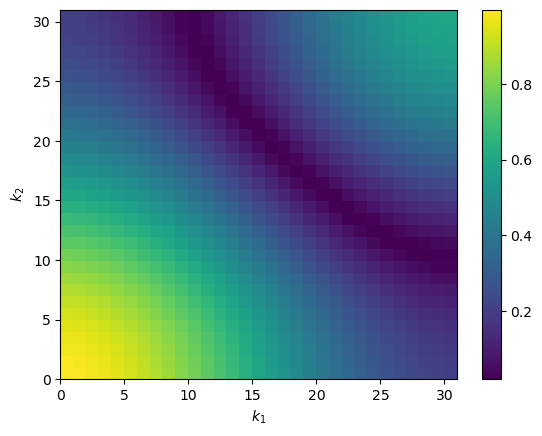

In [4]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
A = poissonop(n, epsilon=1)
f = np.zeros((n,n)).ravel()
z = np.zeros((n,n))
for k1 in range(1,n+1):
    for k2 in range(1,n+1):
        v = np.outer(np.sin(np.arange(1,n+1) * k1 * np.pi / (n+1)),
                     np.sin(np.arange(1,n+1) * k2 * np.pi / (n+1)))
        v = v.ravel()
        nv0 = np.linalg.norm(v)
        m = 10
        v = relaxJ(A, v, f, m)
        nv1 = np.linalg.norm(v)
        z[k1-1,k2-1] = (nv1 / nv0)**(1/m)

plt.pcolor(z)
plt.colorbar()
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')

In [5]:
np.sum(z<0.5)/np.sum(z>0)

0.7200832466181062

0.45161290322580644

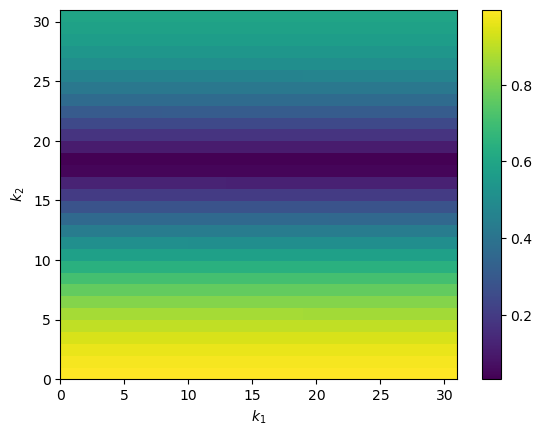

In [6]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
A = poissonop(n, epsilon=0.001)
f = np.zeros((n,n)).ravel()
z = np.zeros((n,n))
for k1 in range(1,n+1):
    for k2 in range(1,n+1):
        v = np.outer(np.sin(np.arange(1,n+1) * k1 * np.pi / (n+1)),
                     np.sin(np.arange(1,n+1) * k2 * np.pi / (n+1)))
        v = v.ravel()
        nv0 = np.linalg.norm(v)
        m = 10
        v = relaxJ(A, v, f, m)
        nv1 = np.linalg.norm(v)
        z[k1-1,k2-1] = (nv1 / nv0)**(1/m)

plt.pcolor(z)
plt.colorbar()
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')
np.sum(z<0.5)/np.sum(z>0)

0.48074921956295524

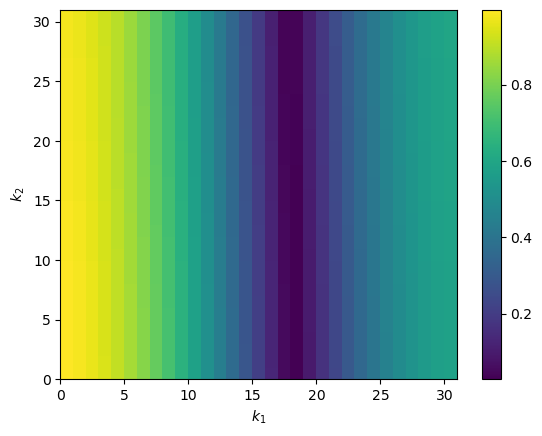

In [7]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
A = poissonop(n, epsilon=100)
f = np.zeros((n,n)).ravel()
z = np.zeros((n,n))
for k1 in range(1,n+1):
    for k2 in range(1,n+1):
        v = np.outer(np.sin(np.arange(1,n+1) * k1 * np.pi / (n+1)),
                     np.sin(np.arange(1,n+1) * k2 * np.pi / (n+1)))
        v = v.ravel()
        nv0 = np.linalg.norm(v)
        m = 10
        v = relaxJ(A, v, f, m)
        nv1 = np.linalg.norm(v)
        z[k1-1,k2-1] = (nv1 / nv0)**(1/m)

plt.pcolor(z)
plt.colorbar()
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')
np.sum(z<0.5)/np.sum(z>0)

Your answer: When dealing with a hard problem, it is best to break it into pieces that you know the answer to and go from there. In a 1D FD mesh (let's call this operator $T_x$, you have the canonical 1,2,1 tridiagonal structure. This leads you to the $\lambda_k^{1\text{D}} = 2 - 2\cos(\theta_k)$, where $\theta_k := \frac{\pi k }{n+1}$, where $n$ is the number of nodes. This same computation outputs the eigenvectors of this operator $T_x$ to be $\omega_k = [0, \sin(\theta_k), \cdots, \sin(i\theta_k), \cdots, \sin(n\theta_k)]^\top$.

However, we know a very relationship between the 1D and 2D problem using Kronecker products. Since we are doing the 1D FD mesh in two independent directions, we can write
$$\left(I_{n_x}\otimes T_x + T_y \otimes I_{n_y} \right)\left(\omega_i\otimes \omega_j\right) = \left(\epsilon \lambda_i + \lambda_j\right)\left(\omega_i\otimes \omega_j\right),$$
where $T_x$ is now a tridiagonal matrix epsilon premultiplied by the 1,2,1 structure and $T_y$ has 1,2,1 tridiagonal structure. Because of this formulation the eigenvalues are $\epsilon\lambda_i+\lambda_j$. 

The below graphs are estimated by using $A(\omega_i\otimes\omega_j) = 0$ as a guess at each point. If the eigenvalue is large, then this corresponds to an oscillatory mode, so smoothing is very efficient. In the first pattern $\epsilon = 1$, so it has this pattern because both $\lambda_i + \lambda_j$ is symmetric. And since we know that we are using the optimal damping of $omega = 4/5$ (not related to the eigenvalues $\omega_i$, then we see a symmetric band of very small magnitudes also symmetrically in the upper right direction, but not completely in the corner, as those values are increasing again. This is because the optimal $\omega = 4/5$ for the 2D problem is optimal smoothing for all of the eigenvalues being considered together, not necessarily optimal for each individual eigenvalue. 

The second graph is when $\epsilon = 0.001, \ll 1$. This shows that large values appear very close to the $k_1$ axis and decrease (and then increase slightly) as you increase along $k_2$. This again can be explained by analyzing the eigenvalues. When $\epsilon\ll 1$, then $\epsilon\lambda_i + \lambda_j\approx \lambda_j$, since the $\epsilon$ term is negligible. This explains why the large values are concentrated in horizontal bands and decrease as you increase along the $k_2$ direction. The end behavior is once again explained by the optimal $\omega$ value.

Similarly, when $\epsilon = 100$, like in the last case $\epsilon\lambda_i + \lambda_j \approx \epsilon\lambda_i$, so we see that the large values are clustered when $k_1$ is small, and have very small impact from $k_2$. Increasing along the $k_1$ direction increases the eigenvalues, which means they are significantly smaller after smoothing. 

## 1.2 Let us try a two grid method on this problem

In [8]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

In [9]:
def trisolver(a, b, c, rhs):
    '''
    https://gist.github.com/TheoChristiaanse/d168b7e57dd30342a81aa1dc4eb3e469
    '''
    nf = len(rhs) # number of equations
    ac, bc, cc, rhsc = map(np.array, (a, b, c, rhs)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1] / bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        rhsc[it] = rhsc[it] - mc*rhsc[it-1]
    xc = bc
    xc[-1] = rhsc[-1] / bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (rhsc[il] - cc[il] * xc[il+1]) / bc[il]

    return xc

In [10]:
def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n, sten):
    #sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    A = stencil_grid(sten, (n, n))
    return A

def getsten(epsilon):
    sten = np.array([[ 0      ,           -1.,  0],
                     [-epsilon,  2+2*epsilon, -epsilon],
                     [0       ,           -1,  0]])
    return sten

### Try smoothing

Let us first use the standard Jacobi smoother to implement the two grid method.


In [11]:
def twogrid(A, P, A1, u0, f0, nu, sten=None):
    u0 = relaxJ(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = relaxJ(A, u0, f0, nu)
    return u0

(0.0, 1.0)

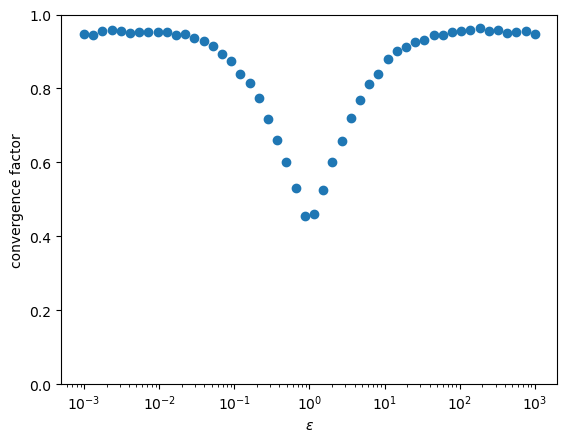

In [12]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)
m=20
allres = np.zeros((len(elist),m))

for i, epsilon in enumerate(elist):
    u = np.random.rand(n*n)
    f = np.zeros((n,n)).ravel()
    sten = getsten(epsilon)
    A = (n+1)**2 * poissonop(n, sten)
    P1d = interpolation1d(nc, n)
    P = sparse.kron(P1d, P1d).tocsr()
    A1 = P.T * A * P
    for j in range(m):
        u = twogrid(A, P, A1, u, f, 1, (n+1)**2 * sten)
        res = np.linalg.norm(f - A * u)
        allres[i,j] = res

factors = []
for i in range(len(elist)):
    factor = (allres[i,-1] / allres[i,-5])**(1/5)
    factors.append(factor)

plt.semilogx(elist, factors, 'o')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')
plt.ylim([0,1])

# Question: We then replace the relaxJ method with the following linerelax method and rerun the above experiment. What is your observation? Please try to eplain why this is the case if you can!!!

After running the above code, it is observed that the convergence factor is very close to 1 when $\epsilon$ is different orders of magnitdue compared to 1. When $\epsilon$ is very small, we see high convergence factor, which means slow convergence. When $\epsilon$ is very large, we again observe this near 1 convergence factor. However, when $\epsilon \approx 1$, then we see that the convergence factor is much smaller at about 0.4. 

Now with running the linerelax method, we observe drastically different behavior. We see that during the small $\epsilon$ regime, the behavior isn't that different from the ```relaxJ``` method. However when $\epsilon>1$, we see that as opposed to the```relaxJ``` case, the values get low around 1 and continue to get smaller and smaller as $\epsilon$ increase to 1000.

One possible explanation for thisw behavior is the following:
First we notice that we are using a Jacobi smoother, which has the form: 
\begin{align}
x_{k+1} &= x_k + \omega D^{-1}\left(f- Ax_k\right)\\
&= \left(I-\omega D^{-1}A\right) x_k + \omega D^{-1}f,
\end{align}
where $\omega$ is the dampening value (optimal is $\omega^\ast = 4/5$). Now we define the distance vector $d_{k+1} = x^\ast - x_{k+1}$, where $x^\ast$ is the true solution. It is not hard to recursively show that
\begin{align}
d_k &= \left(I-\omega D^{-1}A\right)^k d_0\\
&= \left(I-\omega D^{-1}A\right)^k \left(\sum_i \alpha_i \omega_i\right)\\
&= \sum_i \alpha_i\left(I-\omega D^{-1}A\right)^k\omega_i,
\end{align}
where we express $d_0$ as a linear combination of the eigenvectors (as they are linearly independent). Now we turn our attention to the inner part of $\left(I-\omega D^{-1}A\right)$.

We define $D_x := I\otimes T_x + \mathbf{0} \otimes I$. Similarly, $D_y := I\otimes \mathbf{0} + T_y\otimes I $. Observe that the zero matrix $\mathbf{0}$ can be diagonalized trivially with the eigenbasis of either of the two operators $D_x$ or $D_y$, which means their eigenvalues are $(\epsilon \lambda_i + 0)$ and $(0+ \lambda_j)$, respectively. This means that $A := I\otimes T_x + T_y \otimes I$ has eigenvectors $\epsilon\lambda_i + \lambda_j$ and eigenvectors $\omega_i \otimes \omega_j$. We diagonalize both $A$ and $D$ to arrive at
\begin{align}
A &= Q\Lambda_A Q^\top\\
D &= Q\Lambda_D Q^\top\\
\omega D^{-1}A &= \omega Q\Lambda_D^{-1} Q^\top Q\Lambda_A Q^\top\\
&=  \omega Q\Lambda_D^{-1}\Lambda_A Q^\top.
\end{align}

However if we look at $D_x^{-1}A$ and $D_y^{-1}A$, we see
\begin{align}
D_x^{-1}A &= \frac{\epsilon\lambda_i + \lambda_j}{\epsilon\lambda_i}\left(\omega_i \otimes \omega_j\right)\\
D_y^{-1}A &= \frac{\epsilon\lambda_i + \lambda_j}{\lambda_j}\left(\omega_i \otimes \omega_j\right).
\end{align}

Combining it all, we observe:
\begin{align}
\left(I - \omega D_x^{-1}A\right)^k &= \left(1 -\frac{\omega\epsilon\lambda_i + \omega\lambda_j}{\epsilon\lambda_i}\right)^k\left(\omega_i \otimes \omega_j\right)\\
&= \left(\frac{\omega\lambda_j}{\epsilon\lambda_i}\right)^k\left(\omega_i \otimes \omega_j\right)\\
\left(I - \omega D_y^{-1}A\right)^k &= \left( 1 - \frac{\omega\epsilon\lambda_i + \omega\lambda_j}{\lambda_j}\right)^k\left(\omega_i \otimes \omega_j\right)\\
&= \left( \frac{\omega\epsilon\lambda_i}{\lambda_j}\right)^k\left(\omega_i \otimes \omega_j\right)
\end{align}
Clearly, we observe that for the first case, if $\epsilon\ll 1$ then the program will not have great results. This explains the above behavior. Conversely, if $\epsilon\gg1$then the second method will not work well.

In [13]:
def linerelax(A, u, f, nu,
              sten,
              direction='y'):
    """
    'y' -- constant x
    'x' -- constant y
    """
    n = int(np.sqrt(len(f))) # assume a square grid

    # get the stride
    # linesten -- the stencil for the 1d problem
    # offsten -- the weak stencil entries
    if direction == 'x':
        stride = 1
        linesten = sten[1,:]
        offsten = sten[[0,2],1]
    if direction == 'y':
        stride = n
        linesten = sten[:,1]
        offsten = sten[1,[0,2]]

    # build the three vectors for the tridiagonal solver
    T = np.array(linesten) * np.ones((n,3))

    f = f.reshape((n,n))
    unew = u.copy()
    unew = unew.reshape((n,n))

    # for each smoothing pass
    for _ in range(nu):
        # solve each line
        for i in range(n):
            if direction == 'x':
                fline = f[i,:].copy()
                if i > 1:
                    fline -= offsten[0] * unew[i-1,:]
                if i < (n-1):
                    fline -= offsten[1] * unew[i+1,:]

            if direction == 'y':
                fline = f[:,i].copy()
                if i > 1:
                    fline -= offsten[0] * unew[:,i-1]
                if i < (n-1):
                    fline -= offsten[1] * unew[:,i+1]

            uline = trisolver(T[:,0], T[:,1], T[:,2], fline)

            if direction == 'x':
                unew[i,:] = uline
            if direction == 'y':
                unew[:,i] = uline
    return unew.ravel()

In [14]:
def Yourtwogrid(A, P, A1, u0, f0, nu, sten=None):
    u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    return u0

(0.0, 1.0)

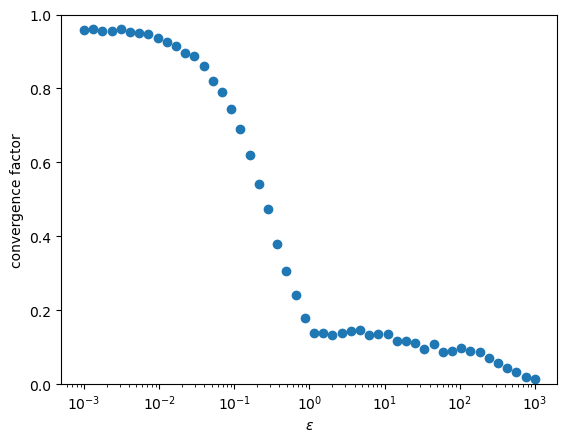

In [15]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)
m=20
allres = np.zeros((len(elist),m))

for i, epsilon in enumerate(elist):
    u = np.random.rand(n*n)
    f = np.zeros((n,n)).ravel()
    sten = getsten(epsilon)
    A = (n+1)**2 * poissonop(n, sten)
    P1d = interpolation1d(nc, n)
    P = sparse.kron(P1d, P1d).tocsr()
    A1 = P.T * A * P
    for j in range(m):
        u = Yourtwogrid(A, P, A1, u, f, 1, (n+1)**2 * sten)
        res = np.linalg.norm(f - A * u)
        allres[i,j] = res

factors = []
for i in range(len(elist)):
    factor = (allres[i,-1] / allres[i,-5])**(1/5)
    factors.append(factor)

plt.semilogx(elist, factors, 'o')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')
plt.ylim([0,1])

# Question: Can you further modify the Yourtwogrid code to make it efficient for all $\epsilon$?

In [16]:
def myYourtwogrid(A, P, A1, u0, f0, nu, epsilon, sten=None):
    if epsilon > 1:
        u0 = linerelax(A, u0, f0, nu, sten, direction='x')
        f1 = P.T * (f0 - A * u0)

        u1 = sla.spsolve(A1, f1)

        u0 = u0 + P * u1
        u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    else:
        u0 = linerelax(A, u0, f0, nu, sten, direction='y')
        f1 = P.T * (f0 - A * u0)

        u1 = sla.spsolve(A1, f1)

        u0 = u0 + P * u1
        u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    return u0

In [17]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)
m=20
allres = np.zeros((len(elist),m))

for i, epsilon in enumerate(elist):
    u = np.random.rand(n*n)
    f = np.zeros((n,n)).ravel()
    sten = getsten(epsilon)
    A = (n+1)**2 * poissonop(n, sten)
    P1d = interpolation1d(nc, n)
    P = sparse.kron(P1d, P1d).tocsr()
    A1 = P.T * A * P
    for j in range(m):
        u = myYourtwogrid(A, P, A1, u, f, 1, epsilon, (n+1)**2 * sten)
        res = np.linalg.norm(f - A * u)
        allres[i,j] = res

factors = []
for i in range(len(elist)):
    factor = (allres[i,-1] / allres[i,-5])**(1/5)
    factors.append(factor)

[]

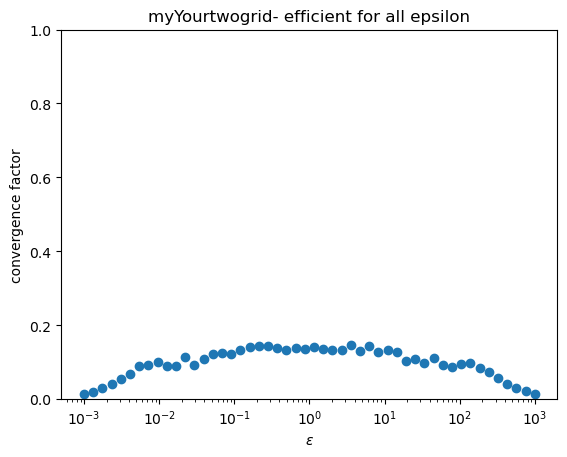

In [18]:
plt.semilogx(elist, factors, 'o')
plt.title('myYourtwogrid- efficient for all epsilon')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')
plt.ylim([0,1])

plt.plot()

Your answer: As you can see with the above code blocks, by defining ```myYourtwogrid``` that now depends on $\epsilon$, we can get very small convergence factors for all values of epsilon. We first check the value of epsilon, and if it is very large, we repeat what was done in the standard ```Yourtwogrid```, which is very efficient for large values of $\epsilon$ as it does the line relax schema in the $x$-direction, as this corresponds to the last case. Going along the $x$-direction when $\epsilon$ is large makes sense because there is a large decrease in the values after smoothing in that case. However, ```Yourtwogrid``` isn't effective in the small $\epsilon$ regime. To modify that when $\epsilon$ is small, ```myYourtwogrid``` will start by going in the $y$ direction which corresponds to the second case, and as a result will see a large decrease in the values. Incorporating the "best-of-both-worlds" approach, we have demonstrated small convergence factor for all $\epsilon$.

This problem tells you that each PDE deserves a specific preconditioner! Constructing preconditioners is more an art than a science. Join us at [Preconditioning 2024](https://www.math.emory.edu/~yxi26/Precond24/) if you are interested in this topic!

# Problem 2. Multigrid on unstructured meshes
In this problem, you will learn how to Algebraic MG method is setup and used for solving unstructured problems.

Load some data

In [19]:
data = pyamg.gallery.load_example('airfoil')
#data = pyamg.gallery.load_example('unit_square')

Create vertices and edges (for plotting)


In [20]:
A = data['A'].tocsr()                              # matrix
V = data['vertices'][:A.shape[0]]                  # vertices of each variable
E = np.vstack((A.tocoo().row,A.tocoo().col)).T  # edges of the matrix graph

create an AMG hierarchy

In [21]:
mls = pyamg.ruge_stuben_solver(A, max_levels=3, max_coarse=1,
                               CF='RS',keep=True)
print(mls)

MultilevelSolver
Number of Levels:     3
Operator Complexity:  1.517
Grid Complexity:      1.369
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0         260         1682 [65.91%]
     1          77          699 [27.39%]
     2          19          171 [6.70%]



In AMG method, the unknowns will be classified into F_nodes (blue) and C_nodes (red) at each level based on some algebraic tests. The C_nodes (red) will be used to form the coarse grid operator based on the matrix-matrix multiplication $RAP$ we discussed during the lecture.

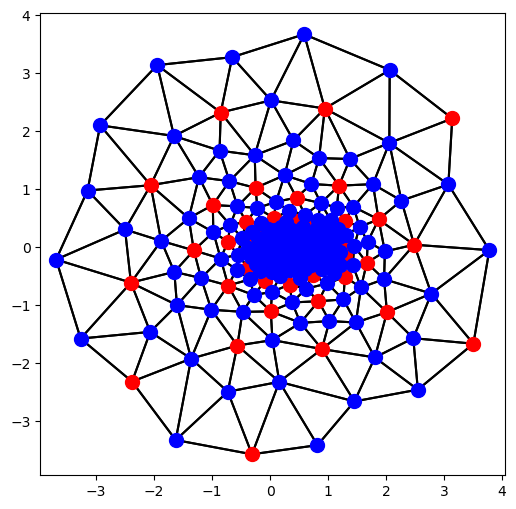

In [22]:
# The CF splitting, 1 == C-node and 0 == F-node
splitting = mls.levels[0].splitting
C_nodes = splitting == 1
F_nodes = splitting == 0

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')

for e in E:
    plt.plot(V[e,0], V[e,1], 'k-', zorder=1)

ax.scatter(V[:,0][C_nodes], V[:,1][C_nodes], c='r', s=100.0, zorder=2)  #plot C-nodes in red
ax.scatter(V[:,0][F_nodes], V[:,1][F_nodes], c='b', s=100.0, zorder=2)  #plot F-nodes in blue
#ax.set_xlim([-0.5,1.5])
#ax.set_ylim([-0.5,0.5])

 let's try a fairly small grid with the following stencil:

In [23]:
#theta = np.pi / 2
theta = np.pi / 4
epsilon = 0.01
nx = 20
ny = nx
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FD', epsilon=epsilon, theta=theta)
print(stencil)
A = pyamg.gallery.stencil_grid(stencil, (nx, ny), format='csr')

[[-0.2475 -0.505   0.2475]
 [-0.505   2.02   -0.505 ]
 [ 0.2475 -0.505  -0.2475]]


###  Build a CF hierarchy

Use `ruge_stuben_solver` to build a CF hierarchy. With a few notes:

- `keep` will simply retain all of the "extra" operators used to build the hierarch.  For example a list of the C/F nodes on each level.
- `strength` sets the strength parameters.  Here `classical` is normally used.  The `norm` equal to `min` (rather than `abs`) avoids using the absolute value in the strength test so that large positive entries are treated as weak connections.

In [24]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.0,
                                         'norm': 'min'}))
print(ml)

MultilevelSolver
Number of Levels:     5
Operator Complexity:  1.806
Grid Complexity:      1.475
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0         400         3364 [55.37%]
     1         133         1689 [27.80%]
     2          44          900 [14.81%]
     3          11          119 [1.96%]
     4           2            4 [0.07%]



In [25]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.0,
                                         'norm': 'min'}))
print(ml)

MultilevelSolver
Number of Levels:     5
Operator Complexity:  1.806
Grid Complexity:      1.475
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0         400         3364 [55.37%]
     1         133         1689 [27.80%]
     2          44          900 [14.81%]
     3          11          119 [1.96%]
     4           2            4 [0.07%]



### View the splitting

We can vew the C/F splitting by inspecting the first `level`.

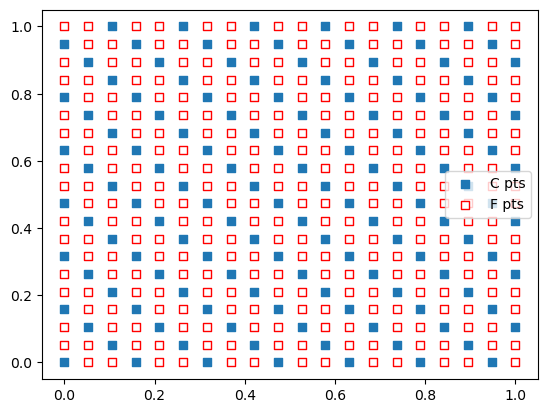

In [26]:
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
X = X.ravel()
Y = Y.ravel()

# The CF splitting, 1 == C-node and 0 == F-node
splitting = ml.levels[0].splitting
C_nodes = splitting == 1
F_nodes = splitting == 0
splittingc = ml.levels[1].splitting
CC_nodes = splittingc == 1
FF_nodes = splittingc == 0

#I = C_nodes
#plt.scatter(X[C_nodes[CC_nodes]], Y[C_nodes[CC_nodes]],
#            marker='*', color='g',
#            s=30.0, label='C pts')
plt.scatter(X[C_nodes], Y[C_nodes],
            marker='s',
            s=30.0, label='C pts')
plt.scatter(X[F_nodes], Y[F_nodes],
            marker='s',
            s=30.0, label='F pts', facecolor='w', edgecolor='r')
plt.legend(frameon=True)

### The `ml` hierarchy

Notice a few things about the hierarchy...

Each level has a number of attributes/functions:
- `A` is the operator on this level
- `P` interpolates **to** this level
- `R` restricts **from** this level.  Simply `R=P.T` in this case.
- `C` is a sparse matrix of strong connections
- `splitting` holds C/F information
- `presmoother` and `postsmoother` point to the relaxation routine

In [27]:
dir(ml.levels[0])

['A',
 'C',
 'P',
 'R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'postsmoother',
 'presmoother',
 'splitting']

- `Operator complexity` is the total sum of the `nnz` in all operators `A` compared to the fine level

In [28]:
Asizes = [ml.levels[i].A.nnz for i in range(len(ml.levels))]
print(Asizes)
print(np.sum(Asizes)/Asizes[0])

[3364, 1689, 900, 119, 4]
1.8061831153388823


- `Grid Complexity` is the total sum of the unknowns per level, compared to the fine level

In [29]:
Asizes = [ml.levels[i].A.shape[0] for i in range(len(ml.levels))]
print(Asizes)
print(np.sum(Asizes)/Asizes[0])

[400, 133, 44, 11, 2]
1.475


### Set up a problem and solve

Now, set $f=0$ and the initial $u$ to random and solve.

Note: you can set `accel='cg'` to use AMG as a preconditioner

In [30]:
f = np.zeros(A.shape[0])
u0 = np.random.randn(A.shape[0])
res = []
u = ml.solve(b=f, x0=u0, residuals=res, accel='cg')

In [31]:
res = np.array(res)
res[1:] / res[:-1]

array([0.01403469, 0.09167428, 0.12097432, 0.15470261, 0.14508073,
       0.10336183, 0.12812002])

### Now let us solve a large problem!!!

In [32]:
theta = np.pi / 4
epsilon = 0.01
nx = 1000
ny = nx
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FD', epsilon=epsilon, theta=theta)
print(stencil)
A = pyamg.gallery.stencil_grid(stencil, (nx, ny), format='csr')

[[-0.2475 -0.505   0.2475]
 [-0.505   2.02   -0.505 ]
 [ 0.2475 -0.505  -0.2475]]


In [33]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.25,
                                         'norm': 'min'}))
print(ml)

MultilevelSolver
Number of Levels:     10
Operator Complexity:  2.260
Grid Complexity:      1.569
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0     1000000      8988004 [44.24%]
     1      333333      4984009 [24.53%]
     2      166666      4468716 [22.00%]
     3       41666       863038 [4.25%]
     4       20665       821995 [4.05%]
     5        5165       151083 [0.74%]
     6        1302        28590 [0.14%]
     7         346         6758 [0.03%]
     8         156         4178 [0.02%]
     9          32          294 [0.00%]



In [34]:
f = np.zeros(A.shape[0])
u0 = np.random.randn(A.shape[0])
rescg = []
u = ml.solve(b=f, x0=u0, residuals=rescg, tol=1e-10, accel='cg')

# Question: Follow the code from the previous cell, and run the MG code as the solver instead of the preconditioner for CG. Please compare the convergence by ploting two residual curves in one plot.

In [35]:
## Your code:
rescg1 = []
u1 = ml.solve(b=f, x0=u0, residuals=rescg1, tol=1e-10)

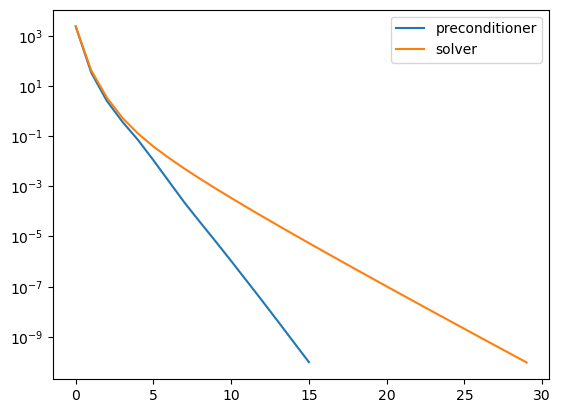

In [36]:
plt.semilogy(rescg)
plt.semilogy(rescg1)
plt.legend(['preconditioner','solver'])
plt.show()